In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [91]:
datadir = 'data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv((datadir + '/driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_248.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_248.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_248.jpg,0.0,0.0,0.0,0.000078
1,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_351.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_351.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_351.jpg,0.0,0.0,0.0,0.000080
2,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_461.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_461.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_461.jpg,0.0,0.0,0.0,0.000078
3,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_564.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_564.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_564.jpg,0.0,0.0,0.0,0.000078
4,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_678.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_678.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_678.jpg,0.0,0.0,0.0,0.000078


In [92]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_03_12_22_04_28_248.jpg,left_2020_03_12_22_04_28_248.jpg,right_2020_03_12_22_04_28_248.jpg,0.0,0.0,0.0,0.000078
1,center_2020_03_12_22_04_28_351.jpg,left_2020_03_12_22_04_28_351.jpg,right_2020_03_12_22_04_28_351.jpg,0.0,0.0,0.0,0.000080
2,center_2020_03_12_22_04_28_461.jpg,left_2020_03_12_22_04_28_461.jpg,right_2020_03_12_22_04_28_461.jpg,0.0,0.0,0.0,0.000078
3,center_2020_03_12_22_04_28_564.jpg,left_2020_03_12_22_04_28_564.jpg,right_2020_03_12_22_04_28_564.jpg,0.0,0.0,0.0,0.000078
4,center_2020_03_12_22_04_28_678.jpg,left_2020_03_12_22_04_28_678.jpg,right_2020_03_12_22_04_28_678.jpg,0.0,0.0,0.0,0.000078


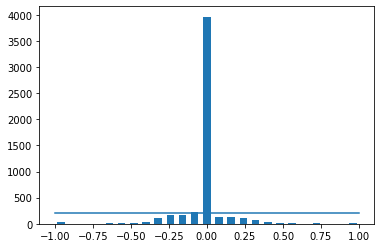

In [93]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total Data 5266
Removed 3778
Remaining 1488


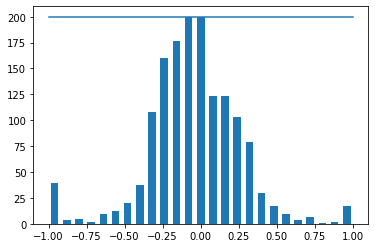

In [94]:
print('Total Data', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print('Removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [95]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(datadir + "/" + center.strip())
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {} \n Valid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1190 
 Valid Samples: 298


Text(0.5, 1.0, 'Validation set')

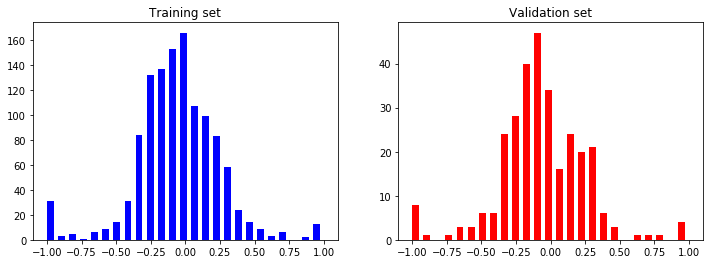

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axs[0].set_title('Training set')
axs[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axs[1].set_title('Validation set')

In [98]:
def image_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

Text(0.5, 1, 'Preprocessed Image')

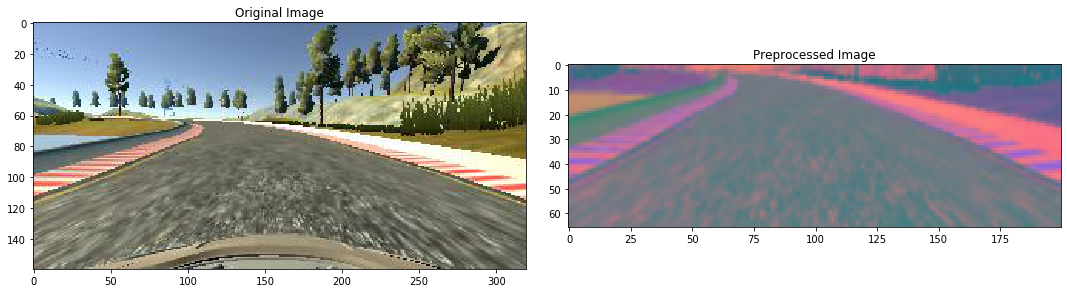

In [99]:
image = image_paths[100]
original = mpimg.imread(image)
preprocessed_image = image_preprocess(image)
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [100]:
X_train = np.array(list(map(image_preprocess, X_train)))
X_valid = np.array(list(map(image_preprocess, X_valid)))

(-0.5, 199.5, 65.5, -0.5)

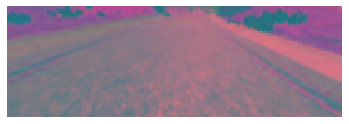

In [101]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')